# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### Problem Statement & Metrics
Using the three datasets, I am going to build a model that predicts whether an offer will be successful or not. First I will cleanse the datasets and then combine them together. I will make a new column of whether the offer went through (was successful).

In order to assess, i will be looking at the naive model which assumes that all offers are successful. This will be the base. We can then evaluate other models and check their accuracy and F1-score. as the F1-score is the combination of precision and recall, this makes a better metric to check performance. 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import datetime
import matplotlib.pyplot as plt 
% matplotlib inline
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.shape

(10, 6)

In [4]:
profile.shape

(17000, 5)

In [5]:
transcript.shape

(306534, 4)

# Data cleaning & preprocessing

In this following section of the code, we will explore our three datasets and set out our problem and target solution.

So from here, we can see that:
The portfolio dataset gives us information about the offers themselves
The profile dataset gives us information about the customers; their age, an ID and other associated information
The transcript dataset gives us a breakdown of which users received which offer and when.

In [6]:
portfolio.head(5)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


### Portfolio

Portfolio: we want to split the channels column up into individual columns per channel type and also split the offer types into columns. We also will then make sure there are no duplicates

In [7]:
channel_type = []

# let's first have a look at all the options for channel types - e.g. how is the offer sent?

for row in portfolio['channels']:
    for item in row:
        if item not in channel_type:
            channel_type.append(item)
            
print(channel_type)

['email', 'mobile', 'social', 'web']


So now we have a list of all of the available channels in our portfolio dataframe. Next we want to make an individual column for each of these and mark it with a 1 if the offer is available through that channel or 0 if it is not.

In [8]:
for channel in channel_type:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)  

In [9]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


Now we can remove the channels column as it is no longer needed.

In [10]:
portfolio.drop('channels', axis=1, inplace=True)

In [11]:
portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [12]:
#let's first have a look at all the options for offer types

offertype_list = portfolio.offer_type.unique()
print(offertype_list)

['bogo' 'informational' 'discount']


In [13]:
portfolio.offer_type.value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

Lets now make new columns for the offer types

In [14]:
for offer in offertype_list:
    portfolio[offer] = portfolio['offer_type'].apply(lambda x: 1 if offer in x else 0)  

In [15]:
portfolio.head(2)

,difficulty,duration,id,offer_type,reward,email,mobile,social,web,bogo,informational,discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0


In [16]:
#will rename the 'id' column to 'offer_id' for clarity
portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [17]:
#lets look at some general info on the df
portfolio.describe()

,difficulty,duration,reward,email,mobile,social,web,bogo,informational,discount
count,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000,1.0,0.900000,0.600000,0.800000,0.400000,0.200000,0.400000
std,5.831905,2.321398,3.583915,0.0,0.316228,0.516398,0.421637,0.516398,0.421637,0.516398
min,0.000000,3.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,5.000000,2.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,8.500000,7.000000,4.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,10.000000,7.000000,5.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,20.000000,10.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
portfolio.dtypes

difficulty        int64
duration          int64
offer_id         object
offer_type       object
reward            int64
email             int64
mobile            int64
social            int64
web               int64
bogo              int64
informational     int64
discount          int64
dtype: object

In [19]:
portfolio.duplicated(subset = 'offer_id')

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
dtype: bool

In [20]:
portfolio.isna().sum()

difficulty       0
duration         0
offer_id         0
offer_type       0
reward           0
email            0
mobile           0
social           0
web              0
bogo             0
informational    0
discount         0
dtype: int64

In [21]:
portfolio.groupby('offer_type')['offer_id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: offer_id, dtype: int64

In [22]:
portfolio.drop('offer_type', axis=1, inplace=True)

We have now finished cleaning up our portfolio dataframe. There are no null values, there are no duplicated entries, the column types are as expected and we have converted our channel types column into separate columns. There are 3 types of offers;
- Bogo
- discount
- informational

We used one hot encoding to split our features into multiple columns.

In [23]:
portfolio.head(5)

,difficulty,duration,offer_id,reward,email,mobile,social,web,bogo,informational,discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,0,1


In [24]:
portfolio.shape

(10, 11)

## Profile dataset

Here we need to check for null values, replace any and remove any duplicates.

- rename the id column to customer_id
- check for duplicates
- look into the customers with age 118
- drop relevant values
- split membeer date into separate columns
- convert relevant columns to 1 and 0


In [25]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [26]:
profile.shape

(17000, 5)

In [27]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [28]:
# lets check for duplicates
profile.columns.duplicated().sum()

0

In [29]:
# lets look at the gender difference of profiles
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [30]:
#check which columns have null values
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [31]:
null_gender_df = profile[profile['gender'].isnull()]

In [32]:
null_gender_df

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [33]:
null_gender_df.age.value_counts()

118    2175
Name: age, dtype: int64

In [34]:
# there are some users in the profiles dataframe who are 118 years old which seems incorrect as currently the eldest person in 
#the world is 116. Therefore I will remove them from the dataframe.
profile.drop(profile.loc[profile['age']==118].index, inplace=True)

In [35]:
# Here I am going to make new columns for the day/month/year when the individual became a member
profile['became_member_year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['became_member_month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
profile['became_member_day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
profile['became_member_date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))

In [36]:
# We need to replace those will NaN income with something else - I am going to take the mean of the other incomes in
#this situation. We also need to replace the missing gender - I am going to replace this with 'U' for Unknown
mean_income = profile.income.mean() # 65404.99
profile['income'].fillna(mean_income, inplace = True)
profile = profile.drop(profile[profile['gender'].isnull()].index)

In [37]:
profile.head(2)

,age,became_member_on,gender,id,income,became_member_year,became_member_month,became_member_day,became_member_date
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,2017-07-15
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,2017-05-09


In [38]:
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [39]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [40]:
# let's now remove any IDs that do not have a gender associated to it, then lets change the gender column to 0/1 
# male/female

In [41]:
profile = profile[profile['gender'] != 'O']

In [42]:
profile.gender[profile.gender == 'M'] = 1
profile.gender[profile.gender == 'F'] = 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
print(len(profile))

14613


In [44]:
# profile.rename(columns={"id": "customer_id"})

In [45]:
profile.head(5)

,age,became_member_on,gender,customer_id,income,became_member_year,became_member_month,became_member_day,became_member_date
1,55,20170715,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,2017-07-15
3,75,20170509,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,2017-05-09
5,68,20180426,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,2018-04-26
8,65,20180209,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,2018-02-09
12,58,20171111,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,2017-11-11


## Transcript

In this case we are going to split our dataframe into two separate ones. This makes more sense for our merge later as we want to predict whether an offer was successful or not. We therefore need to extract the transaction data as this tells us if it was successful or not. 

Now we have a transcript dataframe which gives us the value of an offer, the amount and the type.

In [46]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [47]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [48]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [49]:
# transcript: rename person col name to customer_id.
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [50]:
# Here we are going to make two functions which will separatethe value column into 2 columns - one for the offer_id and
# one for the amount of the offer. This is because some transactions have 'offer id' and some have 'offer_id'

def create_offer_id_col(row):
    if list(row.keys())[0] in ['offer id', 'offer_id']:
        return list(row.values())[0]
    
def create_amount_col(row):
    if list(row.keys())[0] in ['amount']:
        return list(row.values())[0]
    
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
transcript['amount'] = transcript.value.apply(create_amount_col)

# change amount column type to float
transcript.amount.astype('float')

# drop value column
transcript.drop(columns=['value'], inplace=True)

In [51]:
# We only want to keep the transcript rows which are relevant to our customer ids
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [52]:
# here we want to convert the time into days 
transcript['time'] /= 24.0

In [53]:
transcript.duplicated().sum()

368

In [54]:
# Now we need to drop the 368 duplicates
transcript.drop_duplicates(inplace=True)

In [55]:
transcript.head()

,event,customer_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [56]:
# now lets reset the index
transcript.reset_index(drop=True, inplace=True)

In [57]:
transcript.head()

,event,customer_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,NaN
2,offer received,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
3,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,NaN
4,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [58]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268423 entries, 0 to 268422
Data columns (total 5 columns):
event          268423 non-null object
customer_id    268423 non-null object
time           268423 non-null float64
offer_id       146247 non-null object
amount         122176 non-null float64
dtypes: float64(2), object(3)
memory usage: 10.2+ MB


In [60]:
# Now we are going to make a dataframe which looks at only the transaction rows of the dataframe

transaction_df_only = transcript[transcript.event=='transaction'].copy()
transaction_df_only.drop(columns=['offer_id', 'event'], inplace=True)
transaction_df_only.head()

,customer_id,time,amount
10865,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
10868,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
10870,54890f68699049c2a04d415abc25e717,0.0,13.23
10878,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
10879,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [61]:
transaction_df_only.shape

(122176, 3)

In [62]:
# Here we are going to make a dataframe which has removed the transaction events
offers_df = transcript[transcript.event!='transaction'].copy()

# now we are going to one hot encode to make a new column for if an offer was received/completed or viewed
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

offers_df.drop(columns=['event', 'amount'], inplace=True)

In [63]:
transcript.event.value_counts()

transaction        122176
offer received      65585
offer viewed        49087
offer completed     31575
Name: event, dtype: int64

In [64]:
# Now lets check that these numbers match what was in the transcript - yes it does
offers_df.viewed.sum(), offers_df.completed.sum(), offers_df.received.sum()

(49087, 31575, 65585)

In [65]:
offers_df.head()

,customer_id,time,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0


### Now that we have cleaned our data. Let's explore a little and get some insight into our data.


Let's start by looking into our profile dataset and take a look at some of the registered users.

1. First we will look at the gender split in the dataset once we have removed any outlier data points. 

2. Then we will look at the income split based on gender.


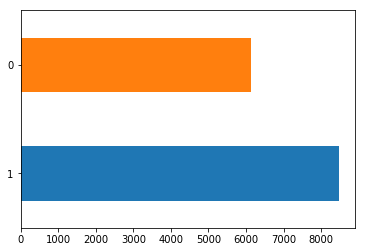

In [66]:
profile['gender'].value_counts().plot(kind='barh')

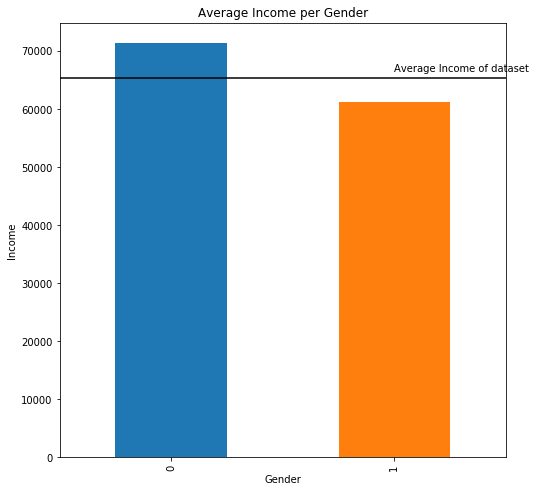

In [67]:
income_by_gender = profile.groupby('gender', as_index=False).agg({'income':'mean'})
income_by_gender.plot(kind = 'bar', x = 'gender', y = 'income', legend=False, figsize=(8,8))
plt.hlines(mean_income, -100 , 1000)
plt.ylabel('Income', fontsize = 10)
plt.xlabel('Gender', fontsize = 10)
plt.title('Average Income per Gender')
plt.text(1, mean_income + 1000, 'Average Income of dataset');

We can see that over half of the people in the Starbucks population are males. We removed any datapoints that did not have data for gender so females make up the rest of the population. We can now look at the average income of each of these genders - females have the highest average income, whereas males are just below the average of the whole dataset.


Now let's look at the different trends regarding when profiles joined the starbucks app/became a member. We can see that there is a steady increase yearly - which would make sense as more and more people using Smartphones and are becoming more equipped with technology. 

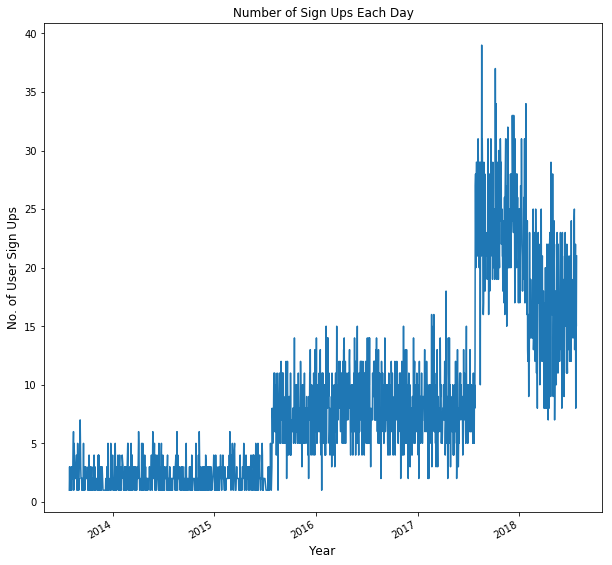

In [68]:
profile.became_member_date.value_counts().plot(kind = 'line', figsize = (10,10))
plt.xlabel('Year', fontsize = 12)
plt.ylabel('No. of User Sign Ups', fontsize = 12)
plt.title('Number of Sign Ups Each Day');

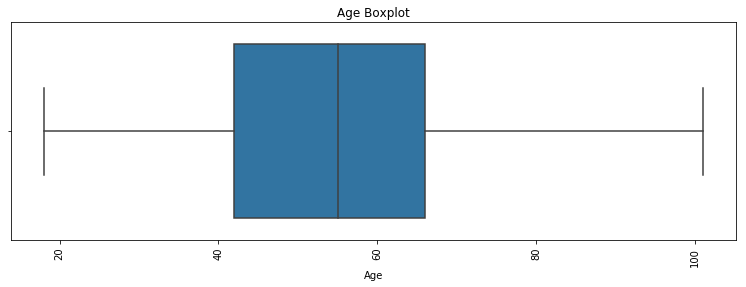

In [69]:
#the age profile boxplot
plt.figure(figsize=(13, 4))
sns.boxplot(profile['age'])
plt.title('Age Boxplot')
plt.xlabel('Age')
plt.xticks(rotation = 90)
plt.show();

In [70]:
portfolio.head()

,difficulty,duration,offer_id,reward,email,mobile,social,web,bogo,informational,discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,0,1


Now let's have a look at the split of the different offer types & which are most common on which platform.

In [71]:
dict = {}
dict['email'] = portfolio.email.sum()
dict['mobile'] = portfolio.mobile.sum()
dict['social'] = portfolio.social.sum()
dict['web'] = portfolio.web.sum()

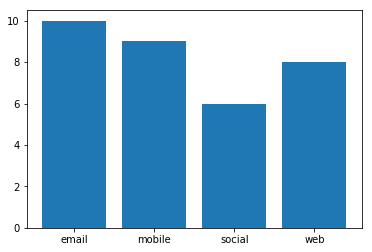

In [72]:
plt.bar(*zip(*dict.items()))
plt.show()

In [73]:
dict_type = {}
dict_type['bogo'] = portfolio.bogo.sum()
dict_type['informational'] = portfolio.informational.sum()
dict_type['discount'] = portfolio.discount.sum()

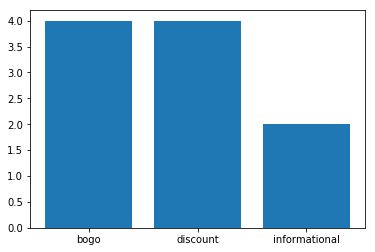

In [74]:
plt.bar(*zip(*dict_type.items()))
plt.show()

In [75]:
#the largest transactions which had an offer associated to it
transaction_df_only.nlargest(5, 'amount')

,customer_id,time,amount
248743,6cf884a6c5ae4b2daccb6d3108028fef,26.25,1062.28
264225,454b00bdd77c4f588eb9f6cafd81dc5d,28.75,1015.73
36958,5ecaea5c8bf44ae4a65838d9d066c909,4.25,1001.85
122801,dce784e26f294101999d000fad9089bb,15.50,989.34
265265,52959f19113e4241a8cb3bef486c6412,29.00,977.78


From this output we can see information on the age of our profiles has a median of around 58 and the majority of profiles are aged between ~41 - 65.

## Modelling

Now let's start modelling. first we will need to combine our three datasets together.

In [76]:
profile.head(5)

,age,became_member_on,gender,customer_id,income,became_member_year,became_member_month,became_member_day,became_member_date
1,55,20170715,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,2017-07-15
3,75,20170509,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,2017-05-09
5,68,20180426,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,2018-04-26
8,65,20180209,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,2018-02-09
12,58,20171111,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,2017-11-11


In [77]:
portfolio.head(5)

,difficulty,duration,offer_id,reward,email,mobile,social,web,bogo,informational,discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,0,1


In [78]:
transaction_df_only.head()

,customer_id,time,amount
10865,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
10868,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
10870,54890f68699049c2a04d415abc25e717,0.0,13.23
10878,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
10879,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [79]:
offers_df.head(5)

,customer_id,time,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0


In [80]:
# merge the data

data = []
customer_ids = offers_df['customer_id'].unique()

# print(customer_ids)

# iterate through the customers
for i in customer_ids:
    
#   get the offers and transactions for that customer_id
    customer_id = i
    customer = profile[profile['customer_id']==customer_id]
    customer_offer_data = offers_df[offers_df['customer_id']==customer_id]
    customer_transaction_data = transaction_df_only[transaction_df_only['customer_id']==customer_id]
    
#   separate the offers into received/completed/viewed
    offer_received_data = customer_offer_data[customer_offer_data['received'] == 1]
    offer_completed_data = customer_offer_data[customer_offer_data['completed'] == 1]
    offer_viewed_data = customer_offer_data[customer_offer_data['viewed'] == 1]
    
    
    rows = []
    
#     go through each of the received offers
    for i in range(offer_received_data.shape[0]):
            
# get the ID associated 
        offer_id = offer_received_data.iloc[i]['offer_id']
            
# extract offer row from portfolio
        offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
# get the offer duration
        duration_time = offer_row['duration'].values[0]
            
# set the start_time of the offer and get the end time (time + duration)
        start_time = offer_received_data.iloc[i]['time']
        end_time = start_time + duration_time
        
# check if the offer was completed within its allocated time (was it successful?)
        offer_completed_in_duration = np.logical_and(offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)

# check if the offer was viewed in the time
        offer_viewed_in_duration = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)
    
# check if therefore the offer is successful - was it viewed and completed in the duration days - 0 if false, 1 if true
        offer_successful = offer_completed_in_duration.sum() > 0 and offer_viewed_in_duration.sum() > 0

# lets see if the transaction then happened in that duration time
        transaction_in_duration = np.logical_and(
                customer_transaction_data['time'] >= start_time, customer_transaction_data['time'] <= end_time)
        

        transaction_data = customer_transaction_data[transaction_in_duration]
        
        transaction_total_amount = transaction_data['amount'].sum()
        
        row = {
                'offer_id': offer_id,
                'customer_id': customer_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
        
        row.update(offer_row.iloc[0,0:].to_dict())

        row.update(customer.iloc[0,:].to_dict())

        rows.append(row)
        
    data.extend(rows)
data = pd.DataFrame(data)
    




In [81]:
data.head()

,age,became_member_date,became_member_day,became_member_month,became_member_on,became_member_year,bogo,customer_id,difficulty,discount,...,income,informational,mobile,offer_id,offer_successful,reward,social,time,total_amount,web
0,75,2017-05-09,9,5,20170509,2017,1,78afa995795e4d85b5d9ceeca43f5fef,5,0,...,100000.0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,0,0.0,37.67,1
1,75,2017-05-09,9,5,20170509,2017,0,78afa995795e4d85b5d9ceeca43f5fef,0,0,...,100000.0,1,1,5a8bc65990b245e5a138643cd4eb9837,0,0,1,7.0,49.39,0
2,75,2017-05-09,9,5,20170509,2017,1,78afa995795e4d85b5d9ceeca43f5fef,10,0,...,100000.0,0,1,ae264e3637204a6fb9bb56bc8210ddfd,1,10,1,17.0,48.28,0
3,75,2017-05-09,9,5,20170509,2017,1,78afa995795e4d85b5d9ceeca43f5fef,5,0,...,100000.0,0,1,f19421c1d4aa40978ebb69ca19b0e20d,1,5,1,21.0,48.28,1
4,68,2018-04-26,26,4,20180426,2018,0,e2127556f4f64592b11af22de27a7932,10,1,...,70000.0,0,1,2906b810c7d4411798c6938adc9daaa5,0,2,0,0.0,0.00,1


In [82]:
# lets reorder the columns 
columns_list = ['time', 'offer_id', 'customer_id', 'total_amount', 
                'offer_successful', 'difficulty', 'duration', 
                'reward', 'bogo', 'discount', 'informational',
                'email', 'mobile', 'social', 'web', 'became_member_date',
                'gender', 'income', 'age', 'became_member_month', 'became_member_day', 'became_member_year']

data[columns_list]

,time,offer_id,customer_id,total_amount,offer_successful,difficulty,duration,reward,bogo,discount,...,mobile,social,web,became_member_date,gender,income,age,became_member_month,became_member_day,became_member_year
0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,37.67,1,5,7,5,1,0,...,1,0,1,2017-05-09,0,100000.0,75,5,9,2017
1,7.0,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,49.39,0,0,3,0,0,0,...,1,1,0,2017-05-09,0,100000.0,75,5,9,2017
2,17.0,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,48.28,1,10,7,10,1,0,...,1,1,0,2017-05-09,0,100000.0,75,5,9,2017
3,21.0,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,48.28,1,5,5,5,1,0,...,1,1,1,2017-05-09,0,100000.0,75,5,9,2017
4,0.0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.00,0,10,7,2,0,1,...,1,0,1,2018-04-26,1,70000.0,68,4,26,2018
5,14.0,3f207df678b143eea3cee63160fa8bed,e2127556f4f64592b11af22de27a7932,0.00,0,0,4,0,0,0,...,1,0,1,2018-04-26,1,70000.0,68,4,26,2018
6,17.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,18.42,1,5,7,5,1,0,...,1,0,1,2018-04-26,1,70000.0,68,4,26,2018
7,21.0,fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,18.42,1,10,10,2,0,1,...,1,1,1,2018-04-26,1,70000.0,68,4,26,2018
8,0.0,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,9.54,1,5,5,5,1,0,...,1,1,1,2018-02-09,1,53000.0,65,2,9,2018
9,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,389bc3fa690240e798340f5a15918d5c,0.00,0,5,7,5,1,0,...,1,0,1,2018-02-09,1,53000.0,65,2,9,2018


In [83]:
# lets save this dataset to we do not need to redo the previous step as it is time consuming
data.to_csv('merged_data.csv', index=False)

In [84]:
data_merged = pd.read_csv('merged_data.csv')

In [85]:
data_merged.head(1)

,age,became_member_date,became_member_day,became_member_month,became_member_on,became_member_year,bogo,customer_id,difficulty,discount,...,income,informational,mobile,offer_id,offer_successful,reward,social,time,total_amount,web
0,75,2017-05-09,9,5,20170509,2017,1,78afa995795e4d85b5d9ceeca43f5fef,5,0,...,100000.0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,0,0.0,37.67,1


In [86]:
column_ordering = ['offer_id', 'total_amount']
column_ordering.extend([element for element in data_merged.columns if element not in column_ordering])

In [87]:
data_merged.head()

,age,became_member_date,became_member_day,became_member_month,became_member_on,became_member_year,bogo,customer_id,difficulty,discount,...,income,informational,mobile,offer_id,offer_successful,reward,social,time,total_amount,web
0,75,2017-05-09,9,5,20170509,2017,1,78afa995795e4d85b5d9ceeca43f5fef,5,0,...,100000.0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,0,0.0,37.67,1
1,75,2017-05-09,9,5,20170509,2017,0,78afa995795e4d85b5d9ceeca43f5fef,0,0,...,100000.0,1,1,5a8bc65990b245e5a138643cd4eb9837,0,0,1,7.0,49.39,0
2,75,2017-05-09,9,5,20170509,2017,1,78afa995795e4d85b5d9ceeca43f5fef,10,0,...,100000.0,0,1,ae264e3637204a6fb9bb56bc8210ddfd,1,10,1,17.0,48.28,0
3,75,2017-05-09,9,5,20170509,2017,1,78afa995795e4d85b5d9ceeca43f5fef,5,0,...,100000.0,0,1,f19421c1d4aa40978ebb69ca19b0e20d,1,5,1,21.0,48.28,1
4,68,2018-04-26,26,4,20180426,2018,0,e2127556f4f64592b11af22de27a7932,10,1,...,70000.0,0,1,2906b810c7d4411798c6938adc9daaa5,0,2,0,0.0,0.00,1


In [88]:
# am going to drop some of the columns as they are not needed for the ML section
data_merged = data_merged[column_ordering]
data_merged = data_merged.drop(columns=['customer_id', 'became_member_on', 'became_member_date'])
data_merged.head()

,offer_id,total_amount,age,became_member_day,became_member_month,became_member_year,bogo,difficulty,discount,duration,email,gender,income,informational,mobile,offer_successful,reward,social,time,web
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,75,9,5,2017,1,5,0,7,1,0,100000.0,0,1,1,5,0,0.0,1
1,5a8bc65990b245e5a138643cd4eb9837,49.39,75,9,5,2017,0,0,0,3,1,0,100000.0,1,1,0,0,1,7.0,0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,75,9,5,2017,1,10,0,7,1,0,100000.0,0,1,1,10,1,17.0,0
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,75,9,5,2017,1,5,0,5,1,0,100000.0,0,1,1,5,1,21.0,1
4,2906b810c7d4411798c6938adc9daaa5,0.00,68,26,4,2018,0,10,1,7,1,1,70000.0,0,1,0,2,0,0.0,1


In [89]:
# lets have a look which offers were successful 
data_merged.offer_successful.value_counts()

0    34729
1    30856
Name: offer_successful, dtype: int64

In [90]:
target = data_merged['offer_successful']
features = data_merged.drop(columns=['offer_successful'])

In [91]:

from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
scaler = MinMaxScaler()
numerical = ['age', 'became_member_day',
             'became_member_month', 'became_member_year','difficulty',
             'duration','reward']
features[numerical] = scaler.fit_transform(features[numerical])

# print to make sure this worked
display(features.head(n = 1))

,offer_id,total_amount,age,became_member_day,became_member_month,became_member_year,bogo,difficulty,discount,duration,email,gender,income,informational,mobile,reward,social,time,web
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,0.686747,0.266667,0.363636,0.8,1,0.25,0,0.571429,1,0,100000.0,0,1,0.5,0,0.0,1


In [92]:
target.head(5)

0    1
1    0
2    1
3    1
4    0
Name: offer_successful, dtype: int64

In [93]:
features.head(5)

,offer_id,total_amount,age,became_member_day,became_member_month,became_member_year,bogo,difficulty,discount,duration,email,gender,income,informational,mobile,reward,social,time,web
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,0.686747,0.266667,0.363636,0.8,1,0.25,0,0.571429,1,0,100000.0,0,1,0.5,0,0.0,1
1,5a8bc65990b245e5a138643cd4eb9837,49.39,0.686747,0.266667,0.363636,0.8,0,0.00,0,0.000000,1,0,100000.0,1,1,0.0,1,7.0,0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,0.686747,0.266667,0.363636,0.8,1,0.50,0,0.571429,1,0,100000.0,0,1,1.0,1,17.0,0
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,0.686747,0.266667,0.363636,0.8,1,0.25,0,0.285714,1,0,100000.0,0,1,0.5,1,21.0,1
4,2906b810c7d4411798c6938adc9daaa5,0.00,0.602410,0.833333,0.272727,1.0,0,0.50,1,0.571429,1,1,70000.0,0,1,0.2,0,0.0,1


In [94]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, test_size=0.3, random_state=42)

In [95]:
X_train

array([['fafdcd668e3743c1bb461111dcafc2a4', 108.58, 0.5421686746987951,
        ..., 1, 7.0, 1],
       ['5a8bc65990b245e5a138643cd4eb9837', 0.0, 0.13253012048192772, ...,
        1, 17.0, 0],
       ['0b1e1539f2cc45b7b9fa7c272da2e1d7', 148.61, 0.08433734939759038,
        ..., 0, 14.0, 1],
       ..., 
       ['2906b810c7d4411798c6938adc9daaa5', 40.21, 0.40963855421686746,
        ..., 0, 17.0, 1],
       ['3f207df678b143eea3cee63160fa8bed', 0.0, 0.3855421686746988, ...,
        0, 7.0, 1],
       ['5a8bc65990b245e5a138643cd4eb9837', 0.0, 0.13253012048192772, ...,
        1, 14.0, 0]], dtype=object)

In [96]:
# we need to have itergers/floats in our columns so lets rewrite out x_train and x_test
X_train = X_train[:, 2:].astype('float64')
X_test = X_test[:, 2:].astype('float64')

# convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

In [97]:
print("Training set has")
print((X_train.shape[0])) 
print("Testing set has ")
print((X_test.shape[0]))

Training set has
45909
Testing set has 
19676


### Model choice
I am now going to run the following models on our train/test dataset.
1. Naive assumption: This takes the assumption that all of the offers are successful. We are not using this as an actual contender as we know this will not give us great results. This will just be a benchmark of the minimum we expect on other models.
2. Logistic Regression: This model is extremely useful for classification as it is useful for understanding the influence of several independednt variables on a single outcome variable. There are however some disadvantages to this model such as assming predictors are independent of each other.
3. Random Forest: This method fits a number of decision trees on various sub-samples or datasets and uses average to improve the predictive accuracy on the model. This is useful for our example as it can reduce overfitting which we see often in Decision Tree Classifiers. The downside to this however is that it can be a lengthy model to run. (which we do see in our case).
4. K-Nearest Neighbours: This is extremely to implement. This method calculates the distances of a new data point to all of the training data points. We will be using Euclidean distance as Manhatten is not appropriate here. I will use a range of K (for k nearest points). One of the negatives of KNN is that is does not work well with high dimension data. As our data has < 15 columns it seems ok to use in this instance. As we have used one hot encoding this should reduce any issues with categorical data.

In [98]:
# Here we are going to look at the accuracy and f1score for the naive assumption, this takes the assumption that all of the 
# outputs are true. 

accuracy_naive_assumption = accuracy_score(y_train, np.ones(len(y_train)))
f1_score_naive = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (accuracy_naive_assumption))
print("Naive predictor f1-score: %.3f" % (f1_score_naive))

Naive predictor accuracy: 0.470
Naive predictor f1-score: 0.639


In [99]:
accuracy_naive_test = accuracy_score(y_test, np.ones(len(y_test)))
f1_score_naive_test = f1_score(y_test, np.ones(len(y_test)))

print("Naive predictor test accuracy: %.3f" % (accuracy_naive_test))
print("Naive predictor test f1-score: %.3f" % (f1_score_naive_test))

Naive predictor test accuracy: 0.472
Naive predictor test f1-score: 0.641


This naive bayes is going to be out baseline. This is when we assume that all of the training dataset outputs were actually 1. here we can see we got 47% accuracy and 64% F1-score on the test dataset.

Now let's look at RandomForestClassifier, LogisticRegression and K-Nearest Neighbour.

In [100]:
def train_predict(classifier, X_train, y_train):
    
    
    y_pred_train = classifier.predict(X_train)
    
    train_results = {}
    
    train_results['Accuracy: training dataset'] = accuracy_score(y_train, y_pred_train)
    train_results['F1-Score: training dataset'] = f1_score(y_train, y_pred_train)

    print (classifier.__class__.__name__)
    
    print(train_results)

    return train_results, y_pred_train

In [101]:
def test_predict(classifier, X_test, y_test):
    
    y_pred_test = classifier.predict(X_test)
    
    test_results = {}
    
    test_results['Accuracy: test dataset'] = accuracy_score(y_test, y_pred_test)
    test_results['F1-score: testing dataset'] = f1_score(y_test, y_pred_test) 
    
    print (classifier.__class__.__name__)
    print(test_results)
    
    return test_results, y_pred_test

In [102]:
scorer = make_scorer(f1_score)

# instantiate a logistic regression classifer object
lr_clf = LogisticRegression(random_state=42, solver='liblinear')

# construct a params dict to tune the model
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.1, 0.01]}

lr_random = RandomizedSearchCV(
    estimator = lr_clf, param_distributions = grid_params, 
    scoring=scorer, n_iter = 6, cv = 3, verbose=2, 
    random_state=42, n_jobs = 3)

# fit train data to the model
LR_classifier = lr_random.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] penalty=l1, C=1.0 ...............................................
[CV] ................................ penalty=l1, C=1.0, total=   5.8s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   0.9s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   1.1s
[CV] penalty=l2, C=1.0 ...............................................
[CV] ................................ penalty=l1, C=1.0, total=   8.3s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................................ penalty=l2, C=1.0, total=   1.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ............

[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:   12.9s finished


In [103]:
logistic_regression_output_train = train_predict(LR_classifier, X_train, y_train)

print('---------------------------------------------------------')

logistic_regression_output_test = test_predict(LR_classifier, X_test, y_test)

RandomizedSearchCV
{'Accuracy: training dataset': 0.71105883377986889, 'F1-Score: training dataset': 0.70993418031532207}
---------------------------------------------------------
RandomizedSearchCV
{'Accuracy: test dataset': 0.71218743647082738, 'F1-score: testing dataset': 0.70984270123482096}


In [104]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

error = []

for i in range(1, 40):
    classifier = KNeighborsClassifier(n_neighbors=i)
    KNN_classifier = classifier.fit(X_train, y_train)
    pred_i = classifier.predict(X_test)
    error.append(np.mean(pred_i != y_test))


Text(0,0.5,'Mean Error')

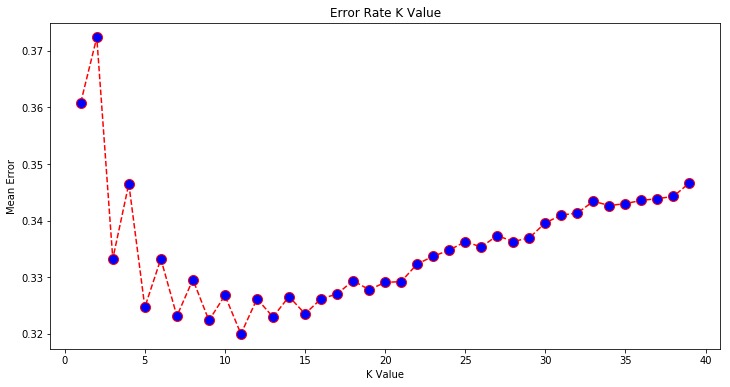

In [105]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

From this graph, this shows us which value of K gives us the lowest/highest mean error. As expected we would like to reduce the error as much as possible. The graph shows us that a value of K=11 gives us the lowest error of 0.32. I will therefore refine this model by using just this value of K. 

I'll then look at the outputs for the training and test data. I have printed the training data predictions to check if our model is overfitting.

In [106]:
classifier_refined = KNeighborsClassifier(n_neighbors=11)
KNN_classifier = classifier_refined.fit(X_train, y_train)
knn_output_train, y_pred_train = train_predict(classifier, X_train, y_train)
knn_output, y_pred_test = test_predict(classifier, X_test, y_test)

KNeighborsClassifier
{'Accuracy: training dataset': 0.68640135921061229, 'F1-Score: training dataset': 0.69668176551142946}
KNeighborsClassifier
{'Accuracy: test dataset': 0.65333401097784105, 'F1-score: testing dataset': 0.66427129989663836}


In [107]:
print('---------------------------------------------------------')
print('Training data:')
print(confusion_matrix(y_train, y_pred_train))
print('---------------------------------------------------------')
print('Testing data:')
print(confusion_matrix(y_test, y_pred_test))

---------------------------------------------------------
Training data:
[[14978  9358]
 [ 5039 16534]]
---------------------------------------------------------
Testing data:
[[6107 4286]
 [2535 6748]]


In [108]:
# initiate randomforestclassifier
rf_clf = RandomForestClassifier(random_state=42)


# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)


# Create the random grid
grid_params = {'n_estimators': [5, 10, 50, 100],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}

# tune the classifer
rf_random = GridSearchCV(estimator = rf_clf,
                               param_grid = grid_params,
                               )

# fit train data to the classifier
rf_random.fit(X_train, y_train)
DT_classifier= rf_random.best_estimator_

In [110]:
randomforest_output_train = train_predict(DT_classifier, X_train, y_train)
print('---------------------------------------------------------')
randomforest_output_test = test_predict(DT_classifier, X_test, y_test)

RandomForestClassifier
{'Accuracy: training dataset': 0.76686488488096016, 'F1-Score: training dataset': 0.76022134103994454}
---------------------------------------------------------
RandomForestClassifier
{'Accuracy: test dataset': 0.74120756251270581, 'F1-score: testing dataset': 0.73134958320143506}


Text(0.5,1,'Feature Importance (Random Forest)')

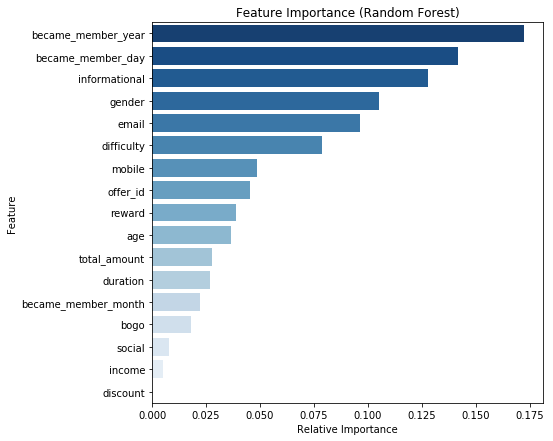

In [111]:
relative_importance = DT_classifier.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(features.columns,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(7, 7))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')

## Conclusion


The aim of this project was to have some insight into the Starbucks dataset and look at general information from it. This involved working on lots of data cleansing as there were quite a few issues with the data such as duplicates and missing data.

I combined the three datasets and made a new column which indicated if the offer had been successful.

I then used accuracy and F1-score to measure my models. I started by taking the naive bayes model which assumes all offers were successful. This gave an accuracy score of around 48%. I then used logistic regression & random forest models & KNN to predict. All of these models had similar accuracy & F1 scores for training and testing dataset which is good as it therefore does not indicate any overfitting.

The final scores for the three models on the were:

### Naive Predictor:

Training accuracy: 0.470

Training f1-score: 0.639

Test test accuracy: 0.472

Test f1-score: 0.641



### Logistic Regression

Training accuracy: 0.71105883377986889

Training F1-score: 0.70993418031532207

Test Accuracy: 0.71218743647082738

Test F1-score: 0.70984270123482096}

### KNearest Neighbour


Training Accuracy: 0.68640135921061229

Training F1-score: 0.69668176551142946

Test Accuracy: 0.65333401097784105

Test F1-score: 0.66427129989663836


### Random forest classfier

Training accracy: 0.76686488488096016, 

Training F1-score: 0.76022134103994454

Test Accuracy: 0.74120756251270581

Test F1-score: 0.73134958320143506


## In the future

Using a range of Machine Learning methods, we were able to take a dataset and predict whether an offer would be successful or not. This was used by spending a significant amount data cleansing & preprocessing. Some insight was given into the data however the bulk of the time was spent on creating and running machine learning models.
It must be highlighted that the best model (RandomForest) took a significant amount of time to run. Even though it has given us the best results, I'm not certain that the percentage in accuracy increase is worth the time element. If we had a bigger dataset this could cause some serious efficiency issues. If I had more time, I would look at feature reduction on RandomForest to see how that would affect our results. Another approach to this dataset would be to create a recommendation engine as this could also give us some interesting insights into how Starbucks should send out offers.

### References

https://stackoverflow.com/

https://medium.com/fuzz/machine-learning-classification-models-3040f71e2529

https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/